This is the version oriented towards the fish paper

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# First Order ODE (y' = f(x, y)) Solver using Euler method
# xa: initial value of independent variable
# xb: final value of independent variable
# ya: initial value of dependent variable
# n : number of steps (higher the better)
# Returns value of y at xb. 
def Euler(f, xa, xb, ya, n):
      h = (xb - xa) / float(n)
      x = xa
      y = ya
      for i in range(n):
          y += h * f(x, y)
          x += h
      return y

# Second Order ODE (y'' = f(x, y, y')) Solver using Euler method
# y1a: initial value of first derivative of dependent variable
def Euler2(f, xa, xb, ya, y1a, n):
      h = (xb - xa) / float(n)
      x = xa
      y = ya
      y1 = y1a
      for i in range(n):
          y1 += h * f(x, y, y1)
          y += h * y1
          x += h
      return y

# print(Euler(lambda x, y: math.cos(x) + math.sin(y), 0, 1, 1, 1000))
# print(Euler2(lambda x, y, y1: math.sin(x * y) - y1, 0, 1, 1, 1, 1000))

In [14]:
# Constants
N=3 # Three Oscillators
ar=0.2 # rad/s
ax=0.2 # rad/s
wn = np.array([[2.0], [2.0], [2.0]]) # natural frequency: "speed"|

In [15]:
# Coupling Weights (in 1/s=Hz)
w = np.matrix([[0,   0.5, 0.5],
               [0.5, 0, 0.5],
               [0.5, 0.5, 0]])
print(w)

[[ 0.   0.5  0.5]
 [ 0.5  0.   0.5]
 [ 0.5  0.5  0. ]]


In [16]:
# Phase Bias (in rad)\
PI = math.pi
phi_fwd = np.matrix([[0    , 0, 0],
                     [0 , 0, 0],
                     [0, 0, 0]])
phi_bwd = np.matrix([[0    , 0, 0],
                     [0 , 0, 0],
                     [0, 0, 0]])
phi_rtr = np.matrix([[0    , 0, 0],
                     [0 , 0, 0],
                     [0, 0, 0]])
phi_rtl = np.matrix([[0    , 0, 0],
                     [0 , 0, 0],
                     [0, 0, 0]])
phi = phi_fwd
print(phi)

[[0 0 0]
 [0 0 0]
 [0 0 0]]


In [17]:
# Target Values
R = np.array([[12.0], [40.0], [40.0]])     # Amplitude
X_fwd = np.array([[0.0], [PI/2], [-PI/2]])    # Offset
X_bwd = np.array([[0.0], [-PI/2], [PI/2]])    # Offset
X_CW = np.array([[0.0], [PI/2], [PI/2]])    # Offset
X_CCW = np.array([[0.0], [-PI/2], [-PI/2]])    # Offset
X = X_fwd

In [18]:
# State Variables
Phi = np.array([[0.0], [0.0], [0.0]])  # Phase
r = np.array([[0.0], [0.0], [0.0]])   # Amplitude
r_d = np.array([[0.0], [0.0], [0.0]])   # Amplit|ude_D
x = np.array([[0.0], [0.0], [0.0]])   # Offset
x_d = np.array([[0.0], [0.0], [0.0]])   # Offset_D

In [19]:
# 1-ODE  for Phi
def f_Phi(Phi, wn, w, phi):
    Phi_j = np.kron(np.transpose(Phi), np.ones((3,1)))
    Phi_i = np.kron(Phi, np.ones((1,3)))
    alpha = np.sin(Phi_j - Phi_i - phi)
    return wn + np.multiply(w,alpha) * r

In [20]:
# 2-ODE for r
def f_r(r, rd, ar, R):
    return ar * ( (ar/4) * (R-r) - rd)

In [21]:
# 2-ODE for x
def f_x(x, xd, ax, X):
    return ax * ( (ax/4) * (X-x) - xd)

In [22]:
def f_theta(x, r, Phi):
    return np.transpose(x - np.asarray(r) * np.sin(np.asarray(Phi)))

In [23]:
def update(wn, w, phi, Phi, r, r_d, x, x_d, ar, ax, h=0.01):
    Phi_d = f_Phi(Phi, wn, w, phi)
    new_Phi = Phi + h * Phi_d
    
    r_dd = f_r(r, r_d, ar, R)
    new_r_d = r_d + h * r_dd
    new_r = r + h * r_d
    
    x_dd = f_x(x, x_d, ax, X)
    new_x_d = x_d + h * x_dd
    new_x = x + h * x_d
    
    Phi = new_Phi
    r = new_r
    r_d = new_r_d
    x = new_x
    x_d = new_x_d
    
    return (Phi, r, r_d, x, x_d)
    

In [24]:
theta = None
Phi_plot = None

# Starts With Forwards
gait_switch = [( 0, X_fwd,"Forward"),
               (12, X_CW, "CWR"),
               (24, X_bwd, 'Backward'),
               (36, X_CCW, "CCWR"),
               (48, X_fwd, 'Forward')]
gait_o = gait_switch

sim_time = 60 # seconds
h = 0.01 # euler step length in seconds
for step in range(0,int(sim_time/h)):
    if len(gait_switch) and step*h > gait_switch[0][0]:
        X = gait_switch[0][1]
        gait_switch = gait_switch[1:]
    
    
    Phi, r, r_d, x, x_d = update(wn, w, Phi, r, r_d, x, x_d, ar, ax, h)
    if theta is None:
        theta = f_theta(x,r,Phi)
        Phi_plot = np.transpose(Phi)
    else:
        theta = np.vstack((theta, f_theta(x,r,Phi)))
        Phi_plot = np.vstack((Phi_plot, np.transpose(Phi)))

ValueError: Image size of 989x74204 pixels is too large. It must be less than 2^16 in each direction.

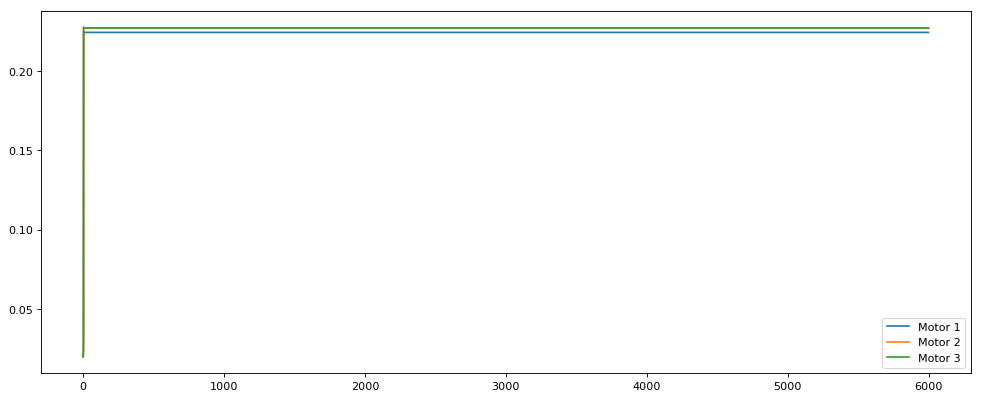

In [25]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt_m1, = plt.plot(theta[:,0], label='Motor 1')
plt_m2, = plt.plot(theta[:,1], label="Motor 2")
plt_m3, = plt.plot(theta[:,2], label="Motor 3")

colors = ['red', 'red', 'green', 'blue','magenta']
# plt.axvspan(0, gait_o[0][0]/h, color=colors[0], alpha=0.1)
# plt.text( (gait_o[0][0]/h - 0)/2, 45, gait_o[0][2] , fontsize=15, horizontalalignment='center')
for idx, gait in enumerate(gait_o[1:]):
    plt.axvspan(gait_o[idx][0]/h, gait_o[idx+1][0]/h, color=colors[idx+1], alpha=0.1)
    plt.text((gait_o[idx+1][0] + gait_o[idx][0])/h/2 , 45, gait_o[idx][2],
             fontsize=15, horizontalalignment='center')
plt.axvspan(gait_o[-1][0]/h, sim_time/h, color='brown', alpha=0.1)
plt.text( (sim_time/h + gait_o[-1][0]/h)/2, 45, gait_o[-1][2] , fontsize=15, horizontalalignment='center')
plt.legend(handles=[plt_m1, plt_m2, plt_m3])


plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt_m1, = plt.plot(Phi_plot[:,0], label='Motor 1')
plt_m2, = plt.plot(Phi_plot[:,1], label="Motor 2")
plt_m3, = plt.plot(Phi_plot[:,2], label="Motor 3")
plt.legend(handles=[plt_m1, plt_m2, plt_m3])